## Задание:

Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH

## Подготовка

In [ ]:
# Импорт библиотек и модулей
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [ ]:
!pip install scikit-video==1.1.11
import skvideo.io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 12.2 MB/s 


In [ ]:
# Гиперпараметры
NUM_TRAIN_ELEM = 500
NUM_FRAMES = 200
NUM_EPOCHS = 5
BATCH_SIZE = 2
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

In [ ]:
# Функция считывания видеофайла и формирования тензора движения
def path_to_motion(video_class, NUM_FRAMES=200):
    videodata = skvideo.io.vread(video_class.numpy()[0].decode('UTF-8'), num_frames=NUM_FRAMES)
    videodata = videodata.astype(np.float32) / 255.
    motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
    return motion, classes.index(video_class.numpy()[1].decode('UTF-8'))

In [ ]:
# Функция установки выходных размеров
# TensorFlow после использования tf.py_function не может установить выходные размеры
def set_shapes(motion, cl_idx):
    motion.set_shape((199, 120, 160, 1))
    cl_idx.set_shape([])
    return motion, cl_idx

## Загрузка и подготовка данных

In [ ]:
# Скачиваем архивы с датасетами
!wget http://www.csc.kth.se/cvap/actions/walking.zip
!wget http://www.csc.kth.se/cvap/actions/jogging.zip
!wget http://www.csc.kth.se/cvap/actions/running.zip
!wget http://www.csc.kth.se/cvap/actions/boxing.zip
!wget http://www.csc.kth.se/cvap/actions/handwaving.zip
!wget http://www.csc.kth.se/cvap/actions/handclapping.zip

--2022-08-22 19:43:46--  http://www.csc.kth.se/cvap/actions/walking.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.csc.kth.se/cvap/actions/walking.zip [following]
--2022-08-22 19:43:47--  https://www.csc.kth.se/cvap/actions/walking.zip
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242442411 (231M) [application/zip]
Saving to: ‘walking.zip’

walking.zip         100%[===================>] 231.21M   595KB/s    in 6m 43s  

2022-08-22 19:50:32 (587 KB/s) - ‘walking.zip’ saved [242442411/242442411]

URL transformed to HTTPS due to an HSTS policy
--2022-08-22 19:50:32--  https://www.csc.kth.se/cvap/actions/jogging.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29

In [ ]:
# Разархивируем данные
!unzip walking.zip -d walking > /dev/null
!unzip jogging.zip -d jogging > /dev/null
!unzip running.zip -d running > /dev/null
!unzip boxing.zip -d boxing > /dev/null
!unzip handwaving.zip -d handwaving > /dev/null
!unzip handclapping.zip -d handclapping > /dev/null

In [ ]:
# Задаем классы
classes = [
          'walking',
          'jogging',
          'running',
          'boxing',
          'handwaving',
          'handclapping',
          ]

In [ ]:
# Создаем датасет из пути к видео и метки класса
dataset_data = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
      dataset_data.append((fpath, cls))
print(f'Количество видеороликов: {len(dataset_data)}')

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping
Количество видеороликов: 599


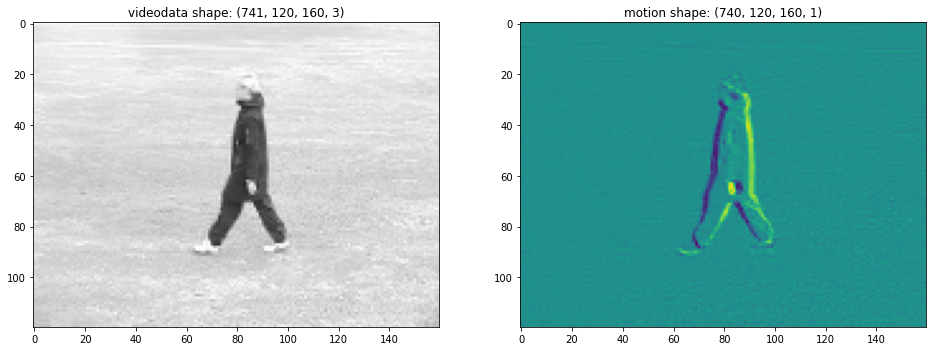

In [ ]:
# Визуализируем кадр из видео
fig = plt.figure(figsize=(16, 8))
ax_1 = fig.add_subplot(1, 2, 1)
videodata = skvideo.io.vread(dataset_data[0][0])
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[50, ...])
plt.title(f'videodata shape: {videodata.shape}')
# Визуализируем кадр движения
ax_2 = fig.add_subplot(1, 2, 2)
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
plt.imshow(motion[50, ..., 0])
plt.title(f'motion shape: {motion.shape}')
plt.show()

In [ ]:
# Разбиваем датасет на обучающий и валидационный
random.shuffle(dataset_data) # сначала перемешиваем датасет

In [ ]:
# Создаем обучающий датасет
train_ds = tf.data.Dataset.from_tensor_slices(dataset_data[:NUM_TRAIN_ELEM])
train_ds = train_ds.shuffle(buffer_size=len(train_ds))
train_ds = train_ds.map(lambda video_class: tf.py_function(func=path_to_motion,
                                                           inp=[video_class], 
                                                           Tout=[tf.float32, tf.uint8]))
train_ds = train_ds.map(lambda x, y: set_shapes(x, y))
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)
print(f'Длина тренировочного датасета: {len(train_ds)}')

Длина тренировочного датасета: 250


In [ ]:
# Создаем тестовый датасет
test_ds = tf.data.Dataset.from_tensor_slices(dataset_data[NUM_TRAIN_ELEM:])
test_ds = test_ds.map(lambda video_class: tf.py_function(func=path_to_motion,
                                                         inp=[video_class], 
                                                         Tout=[tf.float32, tf.uint8]))
test_ds = test_ds.map(lambda x, y: set_shapes(x, y))
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)
print(f'Длина тестового датасета: {len(test_ds)}')

Длина тестового датасета: 49


## Модель нейросетки

In [ ]:
# Создаем модель
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None)
    ])

In [ ]:
# Компиляция модели
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics = ['accuracy']
              )

In [ ]:
%%time
# Обучаем модель
history = model.fit(train_ds,
                    epochs=NUM_EPOCHS,
                    validation_data=test_ds
                    )

Epoch 1/10
250/250 [==============================] - 238s 950ms/step - loss: 0.5607 - accuracy: 0.7820 - val_loss: 0.4352 - val_accuracy: 0.8265
Epoch 2/10
250/250 [==============================] - 239s 957ms/step - loss: 0.3857 - accuracy: 0.8580 - val_loss: 0.2564 - val_accuracy: 0.8776
Epoch 3/10
250/250 [==============================] - 241s 965ms/step - loss: 0.3935 - accuracy: 0.8440 - val_loss: 0.2674 - val_accuracy: 0.8673
Epoch 4/10
250/250 [==============================] - 240s 959ms/step - loss: 0.2473 - accuracy: 0.9040 - val_loss: 0.2395 - val_accuracy: 0.9286
Epoch 5/10
250/250 [==============================] - 244s 974ms/step - loss: 0.2795 - accuracy: 0.8960 - val_loss: 0.4134 - val_accuracy: 0.8673
Epoch 6/10
250/250 [==============================] - 240s 959ms/step - loss: 0.2586 - accuracy: 0.8940 - val_loss: 0.2398 - val_accuracy: 0.9082
Epoch 7/10
250/250 [==============================] - 237s 949ms/step - loss: 0.2075 - accuracy: 0.9160 - val_loss: 0.2420 -

In [ ]:
# Оцениваем качество модели
model.evaluate(test_ds)

49/49 [==============================] - 37s 745ms/step - loss: 0.1452 - accuracy: 0.9388


[0.14515021443367004, 0.9387755393981934]

Не ставил задачи  выбрать лучшую модель, поэтому accuracy не самое большое из возможных на этой модели.

## Тестирование обученной модели

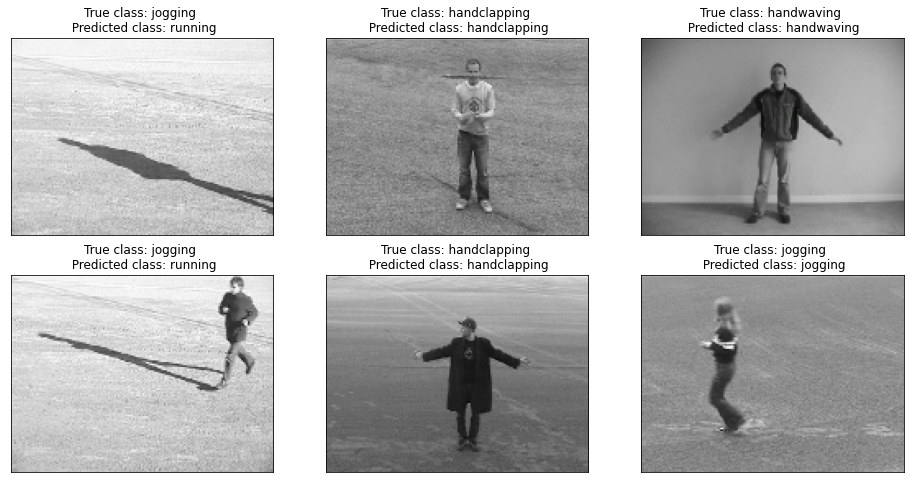

In [ ]:
fpath_cls_true_list = random.sample(dataset_data[NUM_TRAIN_ELEM:], 6) #список из 6 элементов
fig = plt.figure(figsize=(16, 8))
for i in range(len(fpath_cls_true_list)):
  ax = fig.add_subplot(2, 3, i+1)
  videodata = skvideo.io.vread(fpath_cls_true_list[i][0])
  videodata = videodata.astype(np.float32) / 255.
  plt.imshow(videodata[30, ...])
  
  motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
  out = model(motion[None, ...])[0]
  cls_pred = np.argmax(out.numpy())
  plt.title(f'True class: {fpath_cls_true_list[i][1]} \n Predicted class: {classes[cls_pred]}')
  plt.xticks([]), plt.yticks([])
plt.show()

   Не смотря на высокую метрику, модель путает бег с бегом трусцой. С другой стороны на этих кадрах и я бы спутал :).